In [18]:
#　化学シフト差と強度比を求めたデータ（CSVファイル）を用いて、グラフにおこす

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import collections as mcollections 
import re
import tkinter as tk
from tkinter import filedialog
import numpy as np
import os
import traceback # エラー詳細表示用

In [20]:
# --- 4. matplotlibを用いたデータプロット関数 ---
def plot_nmr_data(filepath, total_residues, exclude_outliers=False, outlier_column=None, outlier_threshold=None):
    """
    指定されたCSVファイルからChemical_Shift_DifferenceとIntensity_Ratioを読み込み、
    Assignment列の残基番号を横軸にしてプロットします。
    残基番号の範囲をtotal_residuesで指定し、データがない残基は灰色で表示します。
    外れ値を除外する場合、指定された列と閾値に基づいて残基を除外し、灰色で表示します。
    """
    if not os.path.exists(filepath):
        print(f"エラー: ファイル '{filepath}' が存在しません。")
        return

    if not isinstance(total_residues, int) or total_residues <= 0:
        print(f"エラー: 無効なアミノ酸総数 '{total_residues}' です。正の整数を入力してください。")
        return

    print(f"\n--- NMRデータプロット処理開始 ---")
    print(f"対象ファイル: {os.path.basename(filepath)}")
    print(f"指定されたアミノ酸総数（X軸最大値）: {total_residues}")

    try:
        df = pd.read_csv(filepath, encoding='utf-8')

        print(f"\n--- 読み込んだデータの最初の数行 ---")
        print(df.head())

        required_cols = ['Assignment', 'Chemical_Shift_Difference', 'Intensity_Ratio']
        for col in required_cols:
            if col not in df.columns:
                print(f"エラー: '{os.path.basename(filepath)}' に必要な列 '{col}' が見つかりません。")
                return

        # 'Assignment' 列から残基番号を抽出
        df['Residue_Number'] = df['Assignment'].apply(lambda x: re.search(r'\d+', str(x)).group(0) if re.search(r'\d+', str(x)) else None)
        df['Residue_Number'] = pd.to_numeric(df['Residue_Number'], errors='coerce')

        # 残基番号が抽出できなかった行やNaNになった行を削除
        df.dropna(subset=['Residue_Number'], inplace=True)
        # 残基番号でソート (プロットの線がきれいになるように)
        df.sort_values('Residue_Number', inplace=True)
        
        # 'Residue_Number' を整数型に変換
        df['Residue_Number'] = df['Residue_Number'].astype(int)

        if df.empty:
            print("エラー: 処理できるデータが見つかりませんでした。Assignment列の形式を確認してください。")
            return

        # 全ての残基番号のリストを生成
        all_residues = set(range(1, total_residues + 1))
        # データがある残基番号のセット (初期状態)
        present_residues = set(df['Residue_Number'].unique())
        # データがない残基番号のセット (初期状態)
        missing_residues_initial = all_residues - present_residues
        
        excluded_outlier_residues = set() # 外れ値として除外された残基を格納するセット

        # 外れ値の除外処理
        if exclude_outliers and outlier_column and outlier_threshold is not None:
            # 必要な列がdfに存在するか確認
            if outlier_column not in df.columns:
                print(f"警告: 指定された外れ値対象列 '{outlier_column}' がデータフレームに存在しません。外れ値除外はスキップされます。")
            elif outlier_column not in required_cols[1:]: # Assignmentは数値ではないので除外
                print(f"警告: 指定された外れ値対象列 '{outlier_column}' は数値データ列ではありません。'Chemical_Shift_Difference' または 'Intensity_Ratio' を指定してください。外れ値除外はスキップされます。")
            else:
                initial_df_len = len(df)
                # 外れ値の条件を適用
                outlier_mask = (df[outlier_column] > outlier_threshold)
                
                # 外れ値として除外される残基番号を特定
                excluded_outlier_residues = set(df.loc[outlier_mask, 'Residue_Number'].unique())
                
                # 外れ値を除外したデータフレームを作成
                df = df[~outlier_mask]
                
                print(f"\n--- 外れ値除外情報 ---")
                print(f"対象列: '{outlier_column}', 閾値: > {outlier_threshold}")
                print(f"外れ値として除外された残基数: {len(excluded_outlier_residues)}")
                print(f"除外された残基番号: {sorted(list(excluded_outlier_residues))}")
                print(f"外れ値除外後のデータ行数: {len(df)} (元: {initial_df_len})")

        # 最終的にグラフから除外される（灰色で表示される）残基を結合
        # 初期欠損残基 + 外れ値として除外された残基
        all_excluded_residues = missing_residues_initial.union(excluded_outlier_residues)

        # 虫食い状態（および外れ値）のプロット範囲を準備
        missing_ranges = []
        if all_excluded_residues:
            sorted_excluded = sorted(list(all_excluded_residues))
            start = sorted_excluded[0]
            end = sorted_excluded[0]
            for i in range(1, len(sorted_excluded)):
                if sorted_excluded[i] == end + 1:
                    end = sorted_excluded[i]
                else:
                    missing_ranges.append((start, end)) # axvspanは開始と終了のX座標が必要
                    start = sorted_excluded[i]
                    end = sorted_excluded[i]
            missing_ranges.append((start, end)) # 最後の範囲を追加
        
        print(f"グラフから除外される（灰色で表示される）残基番号: {sorted(list(all_excluded_residues))}")
        print(f"除外残基の描画範囲（開始, 終了）: {missing_ranges}")


        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10), sharex=True) # 2つのサブプロットを作成し、X軸を共有

       # Combined_Shift_Difference のプロット
        # ラベルに数式と改行を追加し、凡例の位置を調整
        chemical_shift_label = ( # 変数名を `chemical_shift_label` に変更
            'Chemical Shift Difference\n'
            r'$\Delta\delta = \sqrt{(\delta H_{\text{free}} - \delta H_{\text{bound}})^2 + \left(\frac{\delta N_{\text{free}} - \delta N_{\text{bound}}}{5}\right)^2}$'
        )
        ax1.plot(df['Residue_Number'], df['Chemical_Shift_Difference'], marker='o', linestyle='-', color='blue', label=chemical_shift_label)
        ax1.set_ylabel('Chemical Shift Difference (ppm)')
        ax1.set_title(f'NMR Data Analysis: {os.path.basename(filepath)}')
        ax1.grid(True, linestyle='--', alpha=0.7)
        # 凡例の位置をグラフ右上（内側）に設定し、文字サイズを調整
        ax1.legend(loc='upper right', fontsize='x-large') # fontsizeを'x-large'に

        ax1.set_xlim(0.5, total_residues + 0.5) # X軸の範囲を1からtotal_residuesまで正確に設定
        # X軸の目盛りを10間隔に、ただし開始は0ではなく1から（またはデータに合わせて調整）
        # total_residuesが169の場合、10間隔で170まで表示
        ax1.set_xticks(np.arange(1, total_residues + 1, 10))
        ax1.set_xticklabels(np.arange(1, total_residues + 1, 10))


        # Intensity_Ratio のプロット
        intensity_ratio_label = ( # 変数名を `intensity_ratio_label` に変更
            'Intensity Ratio\n'
            r'$ file1 / file2 $' # スラッシュ表記に修正
        )
        ax2.plot(df['Residue_Number'], df['Intensity_Ratio'], marker='o', linestyle='-', color='red', label=intensity_ratio_label)
        ax2.set_xlabel('Residue Number')
        ax2.set_ylabel('Intensity Ratio')
        ax2.grid(True, linestyle='--', alpha=0.7)
        # 凡例の位置をグラフ右上（内側）に設定し、文字サイズを調整
        ax2.legend(loc='upper right', fontsize='x-large') # fontsizeを'x-large'に

        ax2.set_xlim(0.5, total_residues + 0.5) # X軸の範囲を1からtotal_residuesまで正確に設定
        # X軸の目盛りを10間隔に
        ax2.set_xticks(np.arange(1, total_residues + 1, 10))
        ax2.set_xticklabels(np.arange(1, total_residues + 1, 10))


        # 欠損残基（および外れ値）の範囲を灰色で描画 (axvspanを使用)
        for start_res, end_res in missing_ranges:
            # 各残基番号は中央にプロットされるため、その「領域」は +/- 0.5 の範囲と考える
            # 例: 残基番号 1 の領域は 0.5 から 1.5
            # start_res の領域の左端 = start_res - 0.5
            # end_res の領域の右端 = end_res + 0.5
            ax1.axvspan(start_res - 0.5, end_res + 0.5, facecolor='lightgray', alpha=0.6, zorder=0)
            ax2.axvspan(start_res - 0.5, end_res + 0.5, facecolor='lightgray', alpha=0.6, zorder=0)
        
        plt.tight_layout() # サブプロット間の余白を調整
        plt.show()

        print(f"\n--- NMRデータプロット処理完了 ---")

    except Exception as e:
        print(f"ファイルの読み込みまたはプロット中にエラーが発生しました: {e}")
        # 詳細なエラー情報を表示
        traceback.print_exc() # これを追加することで、エラーの発生場所と種類が詳しくわかります


--- NMRデータプロットスクリプト開始 ---

--- プロットするCSVファイルを選択してください。（通常は計算結果ファイル） ---
タンパク質のアミノ酸総数（残基の最大番号）を入力してください: 169
外れ値を除外しますか？ (y/n): y
外れ値の対象とする列名を入力してください ('Chemical_Shift_Difference' または 'Intensity_Ratio'): Chemical_Shift_Difference
'Chemical_Shift_Difference' の外れ値のしきい値 (> この値) を入力してください (例: Chemical_Shift_Differenceが6を超える場合 '6'): 2

--- NMRデータプロット処理開始 ---
対象ファイル: 250622.csv
指定されたアミノ酸総数（X軸最大値）: 169

--- 読み込んだデータの最初の数行 ---
  Assignment  w1_file1  w2_file1  Data Height_file1  w1_file2  w2_file2  \
0      T2N-H   121.863     8.508            1478887   121.848     8.509   
1      E3N-H   126.537     8.297            1770082   126.501     8.293   
2      Y4N-H   121.474     8.742             731624   121.283     8.713   
3      K5N-H   124.199     9.145             774235   123.754     9.145   
4      L6N-H   126.565     9.565             536596   126.627     9.342   

   Data Height_file2  w1_diff  w2_diff  Chemical_Shift_Difference  \
0            6664974    0.015   -0.001                   0

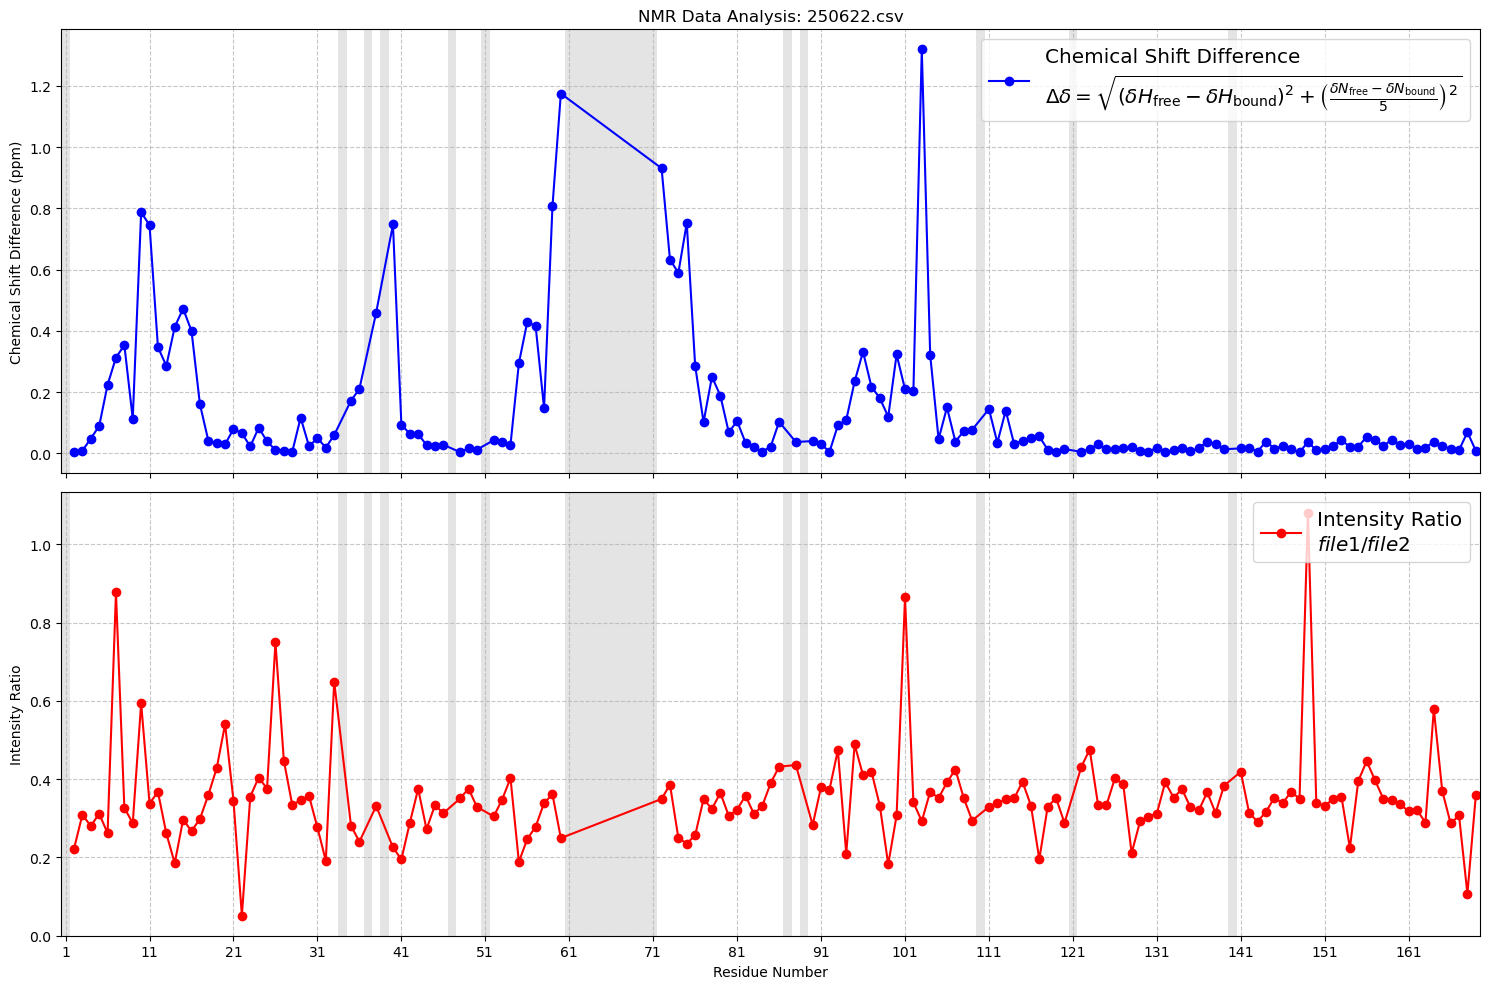


--- NMRデータプロット処理完了 ---

--- スクリプト終了 ---


In [22]:
# --- メイン実行ブロック（プロット部分のみ） ---
if __name__ == "__main__":
    # Tkinterのルートウィンドウを作成（非表示）
    root = tk.Tk()
    root.withdraw()

    print("--- NMRデータプロットスクリプト開始 ---")

    # --- フェーズ3: データプロット ---
    print("\n--- プロットするCSVファイルを選択してください。（通常は計算結果ファイル） ---")
    file_path_to_plot = filedialog.askopenfilename(title="プロット対象のCSVファイルを選択してください", filetypes=[("CSV files", "*.csv"), ("All files", "*.*")])
    
    if file_path_to_plot:
        while True:
            try:
                total_residues_input = input("タンパク質のアミノ酸総数（残基の最大番号）を入力してください: ")
                total_residues = int(total_residues_input)
                if total_residues <= 0:
                    print("エラー: 0より大きい整数を入力してください。")
                else:
                    break
            except ValueError:
                print("エラー: 無効な入力です。整数を入力してください。")

        # 外れ値除外に関するユーザー入力
        exclude_outliers_choice = input("外れ値を除外しますか？ (y/n): ").lower()
        exclude_outliers = (exclude_outliers_choice == 'y')

        outlier_col = None
        outlier_thresh = None

        if exclude_outliers:
            while True:
                outlier_col_input = input("外れ値の対象とする列名を入力してください ('Chemical_Shift_Difference' または 'Intensity_Ratio'): ")
                if outlier_col_input in ['Chemical_Shift_Difference', 'Intensity_Ratio']:
                    outlier_col = outlier_col_input
                    break
                else:
                    print("エラー: 有効な列名を入力してください。")
            
            while True:
                try:
                    outlier_thresh_input = input(f"'{outlier_col}' の外れ値のしきい値 (> この値) を入力してください (例: Chemical_Shift_Differenceが6を超える場合 '6'): ")
                    outlier_thresh = float(outlier_thresh_input)
                    break
                except ValueError:
                    print("エラー: 無効な入力です。数値を入力してください。")

        # plot_nmr_data 関数を呼び出し (外れ値パラメータを追加)
        plot_nmr_data(file_path_to_plot, total_residues, 
                      exclude_outliers=exclude_outliers, 
                      outlier_column=outlier_col, 
                      outlier_threshold=outlier_thresh)
    else:
        print("プロットするファイルが選択されませんでした。処理を終了します。")

    print("\n--- スクリプト終了 ---")